In [9]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy

from models.mgu import MGU

In [2]:
class TestMGU(nn.Module):
    def __init__(self, H_no, in_no, sub_no, C_syn, device):
        super().__init__()
        
        self.H_no = H_no
        self.in_no = in_no
        self.device = device
        self.sub_no = sub_no
        self.C_syn = C_syn
        
        self.scale = nn.Parameter(torch.ones(self.in_no), requires_grad=True)
        
        self.rnn = nn.ModuleList()
        self.linear = nn.ModuleList()
        for s in range(self.sub_no):
            self.rnn.append(MGU(1, self.H_no, True, device))
            self.linear.append(nn.Linear(self.H_no, 1))
        
    def forward(self, S):
        T_data = S.shape[1]
        batch_size = S.shape[0]
        S = S * self.scale.reshape(1,-1)        
        sub_out = torch.ones(batch_size, T_data, self.sub_no).to(self.device)
        S_in = torch.matmul(S, self.C_syn.T)
        
        for s in range(self.sub_no):
            rnn_out = self.rnn[s](S_in[:,:,s].unsqueeze(2))
            lin_out = self.linear[s](rnn_out.reshape(-1,self.H_no)).reshape(batch_size, T_data)
            sub_out[:,:,s] = sub_out[:,:,s] + lin_out
        
        final = torch.sum(sub_out, 2)
        
        return final, sub_out

In [3]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
V_file = "V_diff.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)

In [4]:
T_train = 999 * 1000 * 50
T_test = 1 * 1000 * 50
H_no = 10
sub_no = 4
in_no = 299
device = torch.device("cuda")

batch_length = 50000
batch_size = 9
iter_no = 10000
epoch_no = iter_no*batch_length*batch_size//T_train 

In [5]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
train_E_neural = E_neural[:T_train]
test_E_neural = torch.from_numpy(test_E_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
C_syn = torch.zeros(sub_no, in_no).to(device)
for i in range(in_no):
    idx = e_idx[i]
    if eloc[idx,0] == den_idx[0]:
        C_syn[0,i] = 1
    elif eloc[idx,0] == den_idx[1]:
        C_syn[1,i] = 1
    elif eloc[idx,0] == den_idx[2]:
        C_syn[2,i] = 1
    elif eloc[idx,0] == den_idx[3]:
        C_syn[3,i] = 1

In [7]:
model = TestMGU(H_no, in_no, sub_no, C_syn, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.75)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

1383


In [8]:
for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    V_pred, _= model(batch_E_neural[:,10000:40000,e_idx])
                
    loss = torch.mean((V_pred - batch_V[:,10000:40000])**2)
    loss.backward()
    optimizer.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred, test_sub_out = model(test_E_neural[10000:40000,e_idx].unsqueeze(0))        
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test[10000:40000].cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test[10000:40000]-test_V_pred)**2).item()
                
        print(i, np.round(test_score,6),
              np.round(test_mse,6))


<ipython-input-8-e3b10588a4f3>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 -0.010625 14.542828



KeyboardInterrupt: 

In [9]:
print(model.rnn[0].hidden.shape)

torch.Size([9, 10])


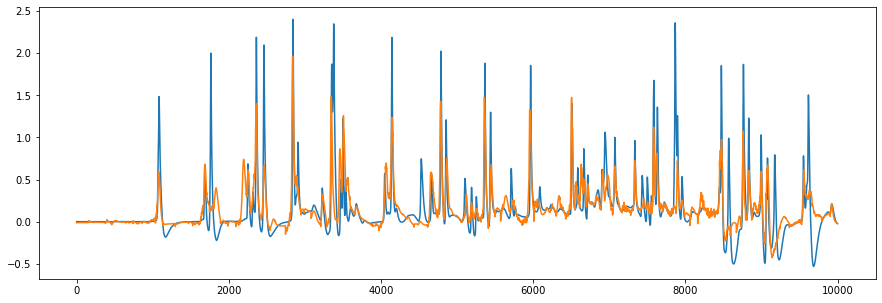

In [9]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000])
#plt.plot(lin_out.flatten().cpu().detach().numpy()[16000:26000])

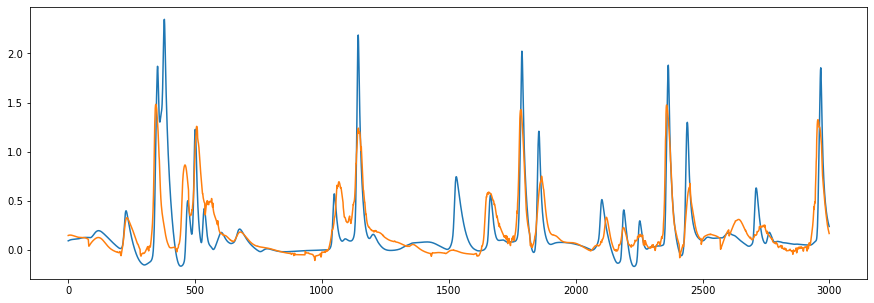

In [10]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000][3000:6000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000][3000:6000])

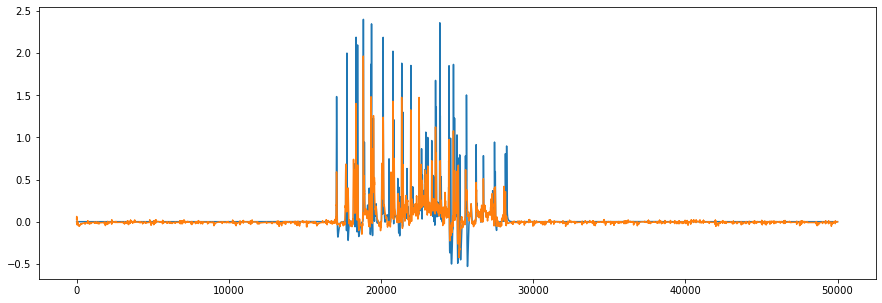

In [11]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy())
plt.plot(test_V_pred.cpu().detach().numpy())